# 48-49 程序性能分析基础

作为拾遗的部分，今天我们来讲讲与Go程序性能分析有关的基础知识。

Go语言为程序开发者们提供了丰富的性能分析API，和非常好用的标准工具。这些API主要存在于：

1. `runtime/pprof`；
2. `net/http/pprof`；
3. `runtime/trace`；
这三个代码包中。

另外，`runtime`代码包中还包含了一些更底层的`API`。它们可以被用来收集或输出Go程序运行过程中的一些关键指标，并帮助我们生成相应的`概要文件`以供后续分析时使用。

至于标准工具，主要有`go tool pprof`和`go tool trace`这两个。它们可以`解析概要文件中的信息`，并以人类易读的方式把这些信息展示出来。

此外，`go test`命令也可以在程序测试完成后生成概要文件。如此一来，我们就可以很方便地使用前面那两个工具读取概要文件，并对被测程序的性能加以分析。这无疑会让程序性能测试的一手资料更加丰富，结果更加精确和可信。

在Go语言中，用于分析程序性能的概要文件有三种，分别是：`CPU概要文件（CPU Profile）`、`内存概要文件（Mem Profile）`和`阻塞概要文件（Block Profile）`。

这些概要文件中包含的都是：**在某一段时间内，对Go程序的相关指标进行多次采样后得到的概要信息。**

对于CPU概要文件来说，**其中的每一段独立的概要信息都记录着，在进行某一次采样的那个时刻，CPU上正在执行的Go代码。**

而对于内存概要文件，其中的每一段概要信息都记载着，**在某个采样时刻，正在执行的Go代码以及堆内存的使用情况，这里包含已分配和已释放的字节数量和对象数量。**至于阻塞概要文件，其中的**每一段概要信息，都代表着Go程序中的一个goroutine阻塞事件。**

注意，在默认情况下，这些概要文件中的信息并不是普通的文本，它们都是以二进制的形式展现的。如果你使用一个常规的文本编辑器查看它们的话，那么肯定会看到一堆“乱码”。

这时就可以显现出`go tool pprof`这个工具的作用了。我们可以通过它进入一个`基于命令行`的交互式界面，并对指定的概要文件进行查阅。就像下面这样：

In [ ]:
$ go tool pprof cpuprofile.out
Type: cpu
Time: Nov 9, 2018 at 4:31pm (CST)
Duration: 7.96s, Total samples = 6.88s (86.38%)
Entering interactive mode (type "help" for commands, "o" for options)
(pprof) 

关于这个工具的具体用法，我就不在这里赘述了。在进入这个工具的交互式界面之后，我们只要输入指令`help`并按下回车键，就可以看到很详细的帮助文档。

**我们现在来说说怎样生成概要文件。**

你可能会问，既然在概要文件中的信息不是普通的文本，那么它们到底是什么格式的呢？一个对广大的程序开发者而言，并不那么重要的事实是，它们是通过`protocol buffers`生成的二进制数据流，或者说字节流。

概括来讲，`protocol buffers`是一种数据序列化协议，同时也是一个序列化工具。它可以把一个值，比如一个结构体或者一个字典，转换成一段字节流。

也可以反过来，把经过它生成的字节流反向转换为程序中的一个值。前者就被叫做`序列化`，而后者则被称为`反序列化`。

换句话说，`protocol buffers`定义和实现了一种“可以让数据在结构形态和扁平形态之间互相转换”的方式。

`Protocol buffers`的优势有不少。比如，它可以在序列化数据的同时对数据进行压缩，所以它生成的字节流，通常都要比相同数据的其他格式（例如XML和JSON）占用的空间明显小很多。

又比如，它既能让我们自己去定义数据序列化和结构化的格式，也允许我们在保证向后兼容的前提下去更新这种格式。

正因为这些优势，Go语言从1.8版本开始，把所有`profile`相关的信息生成工作都交给`protocol buffers`来做了。这也是我们在上述概要文件中，看不到普通文本的根本原因了。

`Protocol buffers`的用途非常广泛，并且在诸如数据存储、数据传输等任务中有着很高的使用率。不过，关于它，我暂时就介绍到这里。你目前知道这些也就足够了。你并不用关心`runtime/pprof`包以及`runtime`包中的程序是如何序列化这些概要信息的。

继续回到怎样生成概要文件的话题，我们依然通过具体的问题来讲述。

**我们今天的问题是：怎样让程序对CPU概要信息进行采样？**

这道题的**典型回答**是这样的。

这需要用到`runtime/pprof`包中的`API`。更具体地说，在我们想让程序开始对CPU概要信息进行采样的时候，需要调用这个代码包中的`StartCPUProfile`函数，而在停止采样的时候则需要调用该包中的`StopCPUProfile`函数。

## 问题解析

`runtime/pprof.StartCPUProfile`函数（以下简称StartCPUProfile函数）在被调用的时候，先会去设定CPU概要信息的`采样频率`，并会在单独的`goroutine`中进行CPU概要信息的收集和输出。

注意，`StartCPUProfile`函数设定的采样频率总是固定的，即：`100赫兹`。也就是说，`每秒采样100次`，或者说每`10`毫秒采样一次。

赫兹，也称Hz，是从英文单词“Hertz”（一个英文姓氏）音译过来的一个中文词。它是CPU主频的基本单位。

CPU的主频指的是，CPU内核工作的时钟频率，也常被称为`CPU clock speed`。这个时钟频率的倒数即为时钟周期（clock cycle），也就是一个CPU内核执行一条运算指令所需的时间，单位是秒。

例如，主频为`1000Hz`的CPU，它的单个内核执行一条运算指令所需的时间为`0.001`秒，即`1`毫秒。又例如，我们现在常用的`3.2GHz`的多核CPU，其单个内核在`1`个纳秒的时间里就可以至少执行三条运算指令。

`StartCPUProfile`函数设定的CPU概要信息采样频率，相对于现代的CPU主频来说是非常低的。这主要有两个方面的原因。

1. 一方面，过高的采样频率会对Go程序的运行效率造成很明显的负面影响。因此，`runtime`包中`SetCPUProfileRate`函数在被调用的时候，会保证采样频率不超过`1MHz`（兆赫），也就是说，它只允许每`1`微秒最多采样一次。`StartCPUProfile`函数正是通过调用这个函数来设定`CPU`概要信息的采样频率的。

2. 另一方面，经过大量的实验，Go语言团队发现`100Hz`是一个比较合适的设定。因为这样做既可以得到足够多、足够有用的概要信息，又不至于让程序的运行出现停滞。另外，操作系统对高频采样的处理能力也是有限的，一般情况下，超过`500Hz`就很可能得不到及时的响应了。

在`StartCPUProfile`函数执行之后，一个新启用的`goroutine`将会负责执行CPU概要信息的收集和输出，直到`runtime/pprof`包中的`StopCPUProfile`函数被成功调用。

`StopCPUProfile`函数也会调用`runtime.SetCPUProfileRate`函数，并把参数值（也就是采样频率）设为`0`。这会让针对CPU概要信息的采样工作停止。

同时，它也会给负责收集`CPU`概要信息的代码一个“信号”，以告知收集工作也需要停止了。

在接到这样的“信号”之后，那部分程序将会把这段时间内收集到的所有CPU概要信息，全部写入到我们在调用`StartCPUProfile`函数的时候指定的写入器中。只有在上述操作全部完成之后，`StopCPUProfile`函数才会返回。

好了，经过这一番解释，你应该已经对CPU概要信息的采样工作有一定的认识了。你可以去看看demo96.go文件中的代码，并运行几次试试。这样会有助于你加深对这个问题的理解。

## 总结

我们这两篇内容讲的是Go程序的性能分析，这其中的内容都是你从事这项任务必备的一些知识和技巧。

首先，我们需要知道，与程序性能分析有关的API主要存在于`runtime`、`runtime/pprof`和`net/http/pprof`这几个代码包中。它们可以帮助我们收集相应的性能概要信息，并把这些信息输出到我们指定的地方。

Go语言的运行时系统会根据要求对程序的相关指标进行多次采样，并对采样的结果进行组织和整理，最后形成一份完整的性能分析报告。这份报告就是我们一直在说的概要信息的汇总。

一般情况下，我们会把概要信息输出到文件。根据概要信息的不同，概要文件的种类主要有三个，分别是：CPU概要文件（CPU Profile）、内存概要文件（Mem Profile）和阻塞概要文件（Block Profile）。

在本文中，我提出了一道与上述几种概要信息有关的问题。在下一篇文章中，我们会继续对这部分问题的探究。

# - 下

## 知识扩展
**问题1：怎样设定内存概要信息的采样频率？**
针对内存概要信息的采样会按照一定比例收集Go程序在运行期间的堆内存使用情况。设定内存概要信息采样频率的方法很简单，只要为`runtime.MemProfileRate`变量赋值即可。

这个变量的含义是，平均每分配多少个字节，就对堆内存的使用情况进行一次采样。如果把该变量的值设为`0`，那么，Go语言运行时系统就会完全停止对内存概要信息的采样。该变量的缺省值是`512` KB，也就是`512`千字节。

注意，如果你要设定这个采样频率，那么越早设定越好，并且只应该设定一次，否则就可能会对Go语言运行时系统的采样工作，造成不良影响。比如，只在`main`函数的开始处设定一次。

在这之后，当我们想获取内存概要信息的时候，还需要调用`runtime/pprof`包中的`WriteHeapProfile`函数。该函数会把收集好的内存概要信息，写到我们指定的写入器中。

注意，我们通过`WriteHeapProfile`函数得到的内存概要信息并不是实时的，它是一个快照，是在最近一次的内存垃圾收集工作完成时产生的。如果你想要实时的信息，那么可以调用`runtime.ReadMemStats`函数。不过要特别注意，该函数会引起Go语言调度器的短暂停顿。

以上，就是关于内存概要信息的采样频率设定问题的简要回答。

**问题2：怎样获取到阻塞概要信息？**

我们调用`runtime`包中的`SetBlockProfileRate`函数，即可对阻塞概要信息的采样频率进行设定。该函数有一个名叫`rate`的参数，它是`int`类型的。

这个参数的含义是，**只要发现一个阻塞事件的持续时间达到了多少个纳秒，就可以对其进行采样。**如果这个参数的值小于或等于0，那么就意味着Go语言运行时系统将会完全停止对阻塞概要信息的采样。

在`runtime`包中，还有一个名叫`blockprofilerate`的包级私有变量，它是`uint64`类型的。这个变量的含义是，只要发现一个阻塞事件的持续时间跨越了多少个`CPU时钟周期`，就可以对其进行采样。它的含义与我们刚刚提到的rate参数的含义非常相似，不是吗？

实际上，这两者的区别仅仅在于单位不同。`runtime.SetBlockProfileRate`函数会先对参数`rate`的值进行单位换算和必要的类型转换，然后，它会把换算结果用原子操作赋给`blockprofilerate`变量。由于此变量的缺省值是`0`，所以Go语言运行时系统在默认情况下并不会记录任何在程序中发生的阻塞事件。

另一方面，当我们需要获取阻塞概要信息的时候，需要先调用`runtime/pprof`包中的`Lookup`函数并传入参数值`"block"`，从而得到一个`*runtime/pprof.Profile`类型的值（以下简称`Profile`值）。在这之后，我们还需要调用这个`Profile`值的`WriteTo`方法，以驱使它把概要信息写进我们指定的写入器中。

这个`WriteTo`方法有两个参数，一个参数就是我们刚刚提到的写入器，它是`io.Writer`类型的。而另一个参数则是代表了概要信息详细程度的`int`类型参数`debug`。

`debug`参数主要的可选值有两个，即：`0`和`1`。当`debug`的值为`0`时，通过`WriteTo`方法写进写入器的概要信息仅会包含`go tool pprof`工具所需的内存地址，这些内存地址会以十六进制的形式展现出来。

当该值为1时，相应的包名、函数名、源码文件路径、代码行号等信息就都会作为注释被加入进去。另外，`debug`为`0`时的概要信息，会经由`protocol buffers`转换为字节流。而在`debug`为`1`的时候，`WriteTo`方法输出的这些概要信息就是我们可以读懂的普通文本了。

除此之外，`debug`的值也可以是`2`。这时，被输出的概要信息也会是普通的文本，并且通常会包含更多的细节。至于这些细节都包含了哪些内容，那就要看我们调用`runtime/pprof.Lookup`函数的时候传入的是什么样的参数值了。下面，我们就来一起看一下这个函数。

**问题 3：`runtime/pprof.Lookup`函数的正确调用方式是什么？**

`runtime/pprof.Lookup`函数（以下简称`Lookup`函数）的功能是，提供与给定的名称相对应的概要信息。这个概要信息会由一个`Profile`值代表。如果该函数返回了一个`nil`，那么就说明不存在与给定名称对应的概要信息。

`runtime/pprof`包已经为我们预先定义了6个概要名称。它们对应的概要信息收集方法和输出方法也都已经准备好了。我们直接拿来使用就可以了。它们是：`goroutine、heap、allocs、threadcreate、block和mutex`。

当我们把"goroutine"传入`Lookup`函数的时候，该函数会利用相应的方法，收集到当前正在使用的所有`goroutine`的堆栈跟踪信息。注意，这样的收集会引起Go语言调度器的短暂停顿。

当调用该函数返回的`Profile`值的`WriteTo`方法时，如果参数`debug`的值大于或等于2，那么该方法就会输出所有`goroutine`的堆栈跟踪信息。这些信息可能会非常多。如果它们占用的空间超过了`64 MB`（也就是64兆字节），那么相应的方法就会将超出的部分截掉。

如果`Lookup`函数接到的参数值是"`heap`"，那么它就会收集与堆内存的分配和释放有关的采样信息。这实际上就是我们在前面讨论过的内存概要信息。在我们传入"`allocs`"的时候，后续的操作会与之非常的相似。

在这两种情况下，`Lookup`函数返回的`Profile`值也会极其相像。只不过，在这两种`Profile`值的`WriteTo`方法被调用时，它们输出的概要信息会有细微的差别，而且这仅仅体现在参数`debug`等于0的时候。

**"`heap`"会使得被输出的内存概要信息默认以“在用空间”（inuse_space）的视角呈现，而"allocs"对应的默认视角则是“已分配空间”（alloc_space）。**

**“在用空间”是指，已经被分配但还未被释放的内存空间。在这个视角下，go tool pprof工具并不会去理会与已释放空间有关的那部分信息。而在“已分配空间”的视角下，所有的内存分配信息都会被展现出来，无论这些内存空间在采样时是否已被释放。**

此外，无论是"heap"还是"allocs"，在我们调用Profile值的WriteTo方法的时候，只要赋予debug参数的值大于`0`，那么该方法输出内容的规格就会是相同的。

参数值"`threadcreate`"会使`Lookup`函数去收集一些堆栈跟踪信息。这些堆栈跟踪信息中的每一个都会描绘出一个代码调用链，这些调用链上的代码都导致新的操作系统线程产生。这样的`Profile`值的输出规格也只有两种，取决于我们传给其`WriteTo`方法的参数值是否大于0。

再说"block"和"mutex"。"block"代表的是，因争用同步原语而被阻塞的那些代码的堆栈跟踪信息。还记得吗？这就是我们在前面讲过的阻塞概要信息。

与之相对应，"mutex"代表的是，曾经作为同步原语持有者的那些代码，它们的堆栈跟踪信息。它们的输出规格也都只有两种，取决于debug是否大于0。

这里所说的同步原语，指的是存在于Go语言运行时系统内部的一种底层的同步工具，或者说一种同步机制。

它是直接面向内存地址的，并以异步信号量和原子操作作为实现手段。我们已经熟知的通道、互斥锁、条件变量、”WaitGroup“，以及Go语言运行时系统本身，都会利用它来实现自己的功能。

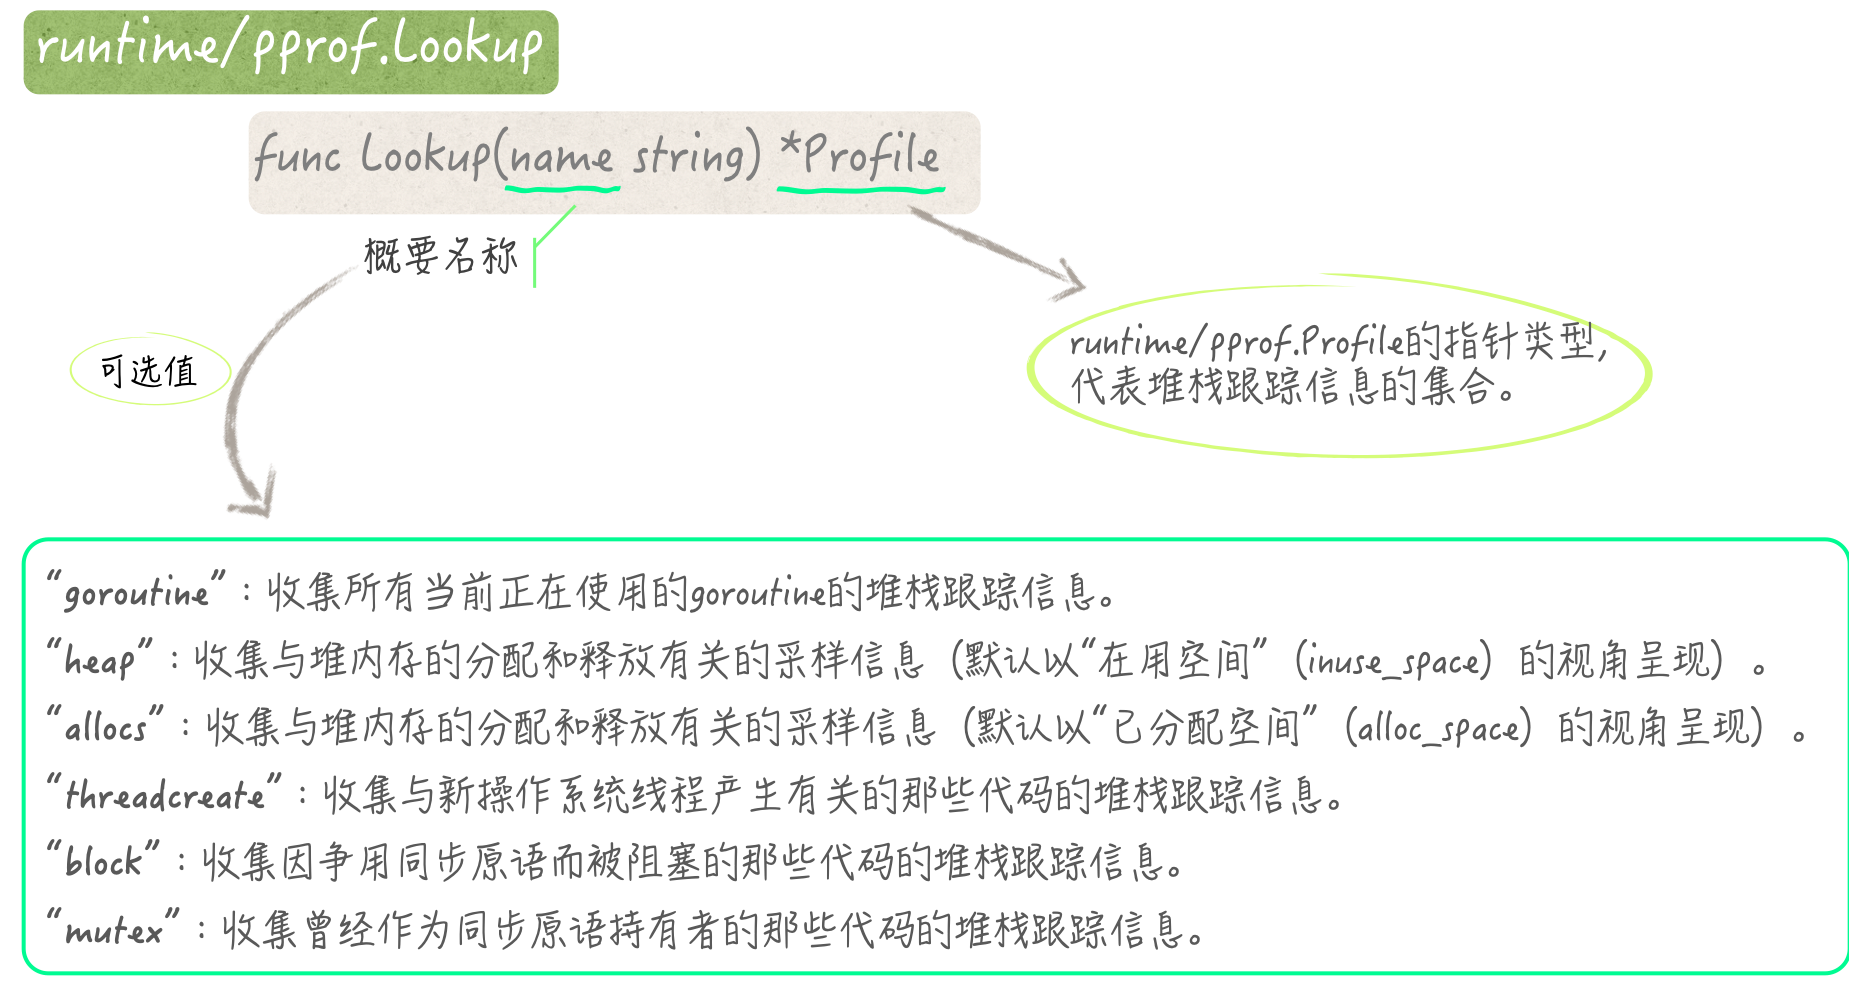

好了，关于这个问题，我们已经谈了不少了。我相信，你已经对Lookup函数的调用方式及其背后的含义有了比较深刻的理解了。demo99.go文件中包含了一些示例代码，可供你参考。
**问题4：如何为基于HTTP协议的网络服务添加性能分析接口？**

这个问题说起来还是很简单的。这是因为我们在一般情况下只要在程序中导入`net/http/pprof`代码包就可以了，就像这样：

In [ ]:
import _ "net/http/pprof"

然后，启动网络服务并开始监听，比如：

In [ ]:
log.Println(http.ListenAndServe("localhost:8082", nil))

在运行这个程序之后，我们就可以通过在网络浏览器中访问`http://localhost:8082/debug/pprof`这个地址看到一个简约的网页。如果你认真地看了上一个问题的话，那么肯定可以快速搞明白这个网页中各个部分的含义。

在`/debug/pprof/`这个URL路径下还有很多可用的子路径，这一点你通过点选网页中的链接就可以了解到。像`allocs、block、goroutine、heap、mutex、threadcreate`这6个子路径，在底层其实都是通过`Lookup`函数来处理的。关于这个函数，你应该已经很熟悉了。

这些子路径都可以接受查询参数`debug`。它用于控制概要信息的格式和详细程度。至于它的可选值，我就不再赘述了。它的缺省值是0。另外，还有一个名叫`gc`的查询参数。它用于控制是否在获取概要信息之前强制地执行一次垃圾回收。只要它的值大于0，程序就会这样做。不过，这个参数仅在`/debug/pprof/heap`路径下有效。

一旦`/debug/pprof/profile`路径被访问，程序就会去执行对CPU概要信息的采样。它接受一个名为`seconds`的查询参数。该参数的含义是，**采样工作需要持续多少秒**。如果这个参数未被显式地指定，那么采样工作会持续30秒。注意，在这个路径下，程序只会响应经`protocol buffers`转换的字节流。我们可以通过`go tool pprof`工具直接读取这样的HTTP响应，例如：

In [ ]:
go tool pprof http://localhost:6060/debug/pprof/profile?seconds=60

除此之外，还有一个值得我们关注的路径，即：`/debug/pprof/trace`。在这个路径下，程序主要会利用`runtime/trace`代码包中的API来处理我们的请求。

更具体地说，程序会先调用`trace.Start`函数，然后在查询参数seconds指定的持续时间之后再调用`trace.Stop`函数。这里的seconds的缺省值是1秒。至于`runtime/trace`代码包的功用，我就留给你自己去查阅和探索吧。

前面说的这些URL路径都是固定不变的。这是默认情况下的访问规则。我们还可以对它们进行定制，就像这样：

In [ ]:
mux := http.NewServeMux() // 创建了一个新的,独立的多路复用器
pathPrefix := "/d/pprof/" // 定义了一个自定义的URL前缀
mux.HandleFunc(pathPrefix, 
    func(w http.ResponseWriter, r *http.Request) {
        // 1. 获取子路径名。
        // 比如访问 /d/pprof/heap，去掉前缀后 name 就是 "heap"
        name := strings.TrimPrefix(r.URL.Path, pathPrefix)
        
        // 2. 如果有子路径名（如 heap, goroutine, block 等）
        if name != "" {
            // 动态获取对应的 pprof handler 并执行
            pprof.Handler(name).ServeHTTP(w, r)
            return
        }
        
        // 3. 如果 name 为空（即访问的是 /d/pprof/），则显示首页索引
        pprof.Index(w, r)
    })
mux.HandleFunc(pathPrefix+"cmdline", pprof.Cmdline)
mux.HandleFunc(pathPrefix+"profile", pprof.Profile)
mux.HandleFunc(pathPrefix+"symbol", pprof.Symbol)
mux.HandleFunc(pathPrefix+"trace", pprof.Trace)

server := http.Server{
	Addr:    "localhost:8083",
	Handler: mux,
}

可以看到，我们几乎只使用了`net/http/pprof`代码包中的几个程序实体，就完成了这样的定制。这在我们使用第三方的网络服务开发框架时尤其有用。

我们自定义的`HTTP`请求多路复用器`mux`所包含的访问规则与默认的规则很相似，只不过`URL`路径的前缀更短了一些而已。

我们定制`mux`的过程与`net/http/pprof`包中的`init`函数所做的事情也是类似的。这个`init`函数的存在，其实就是我们在前面仅仅导入”`net/http/pprof`”代码包就能够访问相关路径的原因。

在我们编写网络服务程序的时候，使用`net/http/pprof`包要比直接使用`runtime/pprof`包方便和实用很多。通过合理运用，这个代码包可以为网络服务的监测提供有力的支撑。关于这个包的知识，我就先介绍到这里。

## 总结

这两篇文章中，我们主要讲了Go程序的性能分析，提到的很多内容都是你必备的知识和技巧。这些有助于你真正地理解以采样、收集、输出为代表的一系列操作步骤。

我提到的几种概要信息有关的问题。你需要记住的是，每一种概要信息都代表了什么，它们分别都包含了什么样的内容。

你还需要知道获取它们的正确方式，包括怎样启动和停止采样、怎样设定采样频率，以及怎样控制输出内容的格式和详细程度。

此外，`runtime/pprof`包中的`Lookup`函数的正确调用方式也很重要。对于除了`CPU`概要信息之外的其他概要信息，我们都可以通过调用这个函数获取到。

除此之外，我还提及了一个上层的应用，即：为基于`HTTP`协议的网络服务，添加性能分析接口。这也是很实用的一个部分。

虽然`net/http/pprof`包提供的程序实体并不多，但是它却能够让我们用不同的方式，实现性能分析接口的嵌入。这些方式有的是极简的、开箱即用的，而有的则用于满足各种定制需求。

以上这些，就是我今天为你讲述的Go语言知识，它们是程序性能分析的基础。如果你把Go语言程序运用于生产环境，那么肯定会涉及它们。对于这里提到的所有内容和问题，我都希望你能够认真地去思考和领会。这样才能够让你在真正使用它们的时候信手拈来。

## 思考题
我今天留给你的思考题其实在前面已经透露了，那就是：runtime/trace代码包的功用是什么？

答：简单来说，这个代码包是用来帮助Go程序实现内部跟踪操作的。其中的程序实体可以帮助我们记录程序中各个goroutine的状态、各种系统调用的状态，与GC有关的各种事件，以及内存相关和CPU相关的变化，等等。

通过它们生成的跟踪记录可以通过go tool trace命令来查看。更具体的说明可以参看runtime/trace代码包的文档。

有了runtime/trace代码包，我们就可以为Go程序加装上可以满足个性化需求的跟踪器了。Go语言标准库中有的代码包正是通过使用该包实现了自身的功能，例如net/http/pprof包。